In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
# Read and downsize dataset to reduce computation
dataframe = pd.read_csv("./credit_card_dataset.csv")
dataframe = dataframe.sample(50000, random_state=1234)


# dataframe_features = dataframe.drop(columns="Class")
# feature_size = len(dataframe.columns)-1
# raw_data = dataframe_features.values
# normal_dataframe = dataframe[dataframe["Class"]==0]
# outliers_dataframe = dataframe[dataframe["Class"]==1]

In [3]:
# Select the top n features
data_norm = MinMaxScaler().fit_transform(dataframe.values)

n = 10
selector = SelectKBest(chi2, k=n)
data_new = selector.fit_transform(data_norm, dataframe["Class"])

feature_support = selector.get_support()
selected_features = dataframe.loc[:,feature_support].columns

# Prepare transformed dataset with reduced features as dataframe
reduced_df = pd.DataFrame(data = data_new, columns = selected_features)

In [4]:
# Prepare dataset for autoencoder
raw_data = reduced_df.values
feature_size = len(selected_features)-1

# The last column contains the labels
labels = raw_data[:, -1]

# The other columns consist of selected features
data = raw_data[:, 0:-1]

In [5]:
# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=7)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [6]:
# Differentiate between normal and anomalous datasets
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

In [7]:
# Define an anomaly detector model as an autoencoder
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(feature_size, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [8]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='MAE')

In [9]:
# Train the autoencoder on the normal dataset
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=32,
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/20
1248/1248 [==============================] - 2s 2ms/step - loss: 0.0376 - val_loss: 0.0293
Epoch 2/20
1248/1248 [==============================] - 2s 2ms/step - loss: 0.0250 - val_loss: 0.0238
Epoch 3/20
1248/1248 [==============================] - 2s 2ms/step - loss: 0.0236 - val_loss: 0.0234
Epoch 4/20
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0227 - val_loss: 0.0212
Epoch 5/20
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0206 - val_loss: 0.0193
Epoch 6/20
1248/1248 [==============================] - 2s 2ms/step - loss: 0.0192 - val_loss: 0.0199
Epoch 7/20
1248/1248 [==============================] - 2s 1ms/step - loss: 0.0190 - val_loss: 0.0195
Epoch 8/20
1248/1248 [==============================] - 2s 2ms/step - loss: 0.0187 - val_loss: 0.0186
Epoch 9/20
1248/1248 [==============================] - 2s 2ms/step - loss: 0.0187 - val_loss: 0.0186
Epoch 10/20
1248/1248 [==============================] - 2s 2ms/step - loss: 0.018

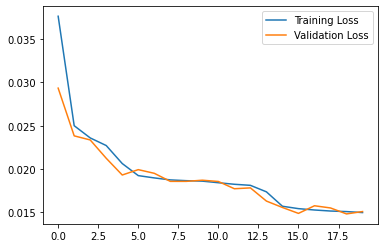

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [11]:
# Compute reconstruction error of normal test data
reconstructions = autoencoder.predict(normal_test_data)
train_loss = tf.keras.losses.MAE(reconstructions, normal_test_data)

In [12]:
# Initial ansatz for threshold
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.02410446


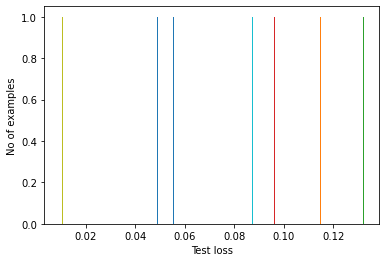

In [13]:
# Compute reconstruction error of anomalous test data
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.MAE(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [14]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.MAE(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [15]:
# Evaluate performance
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.1137
Precision = 0.00011296882060551288
Recall = 0.07692307692307693


In [16]:
# Evaluate performance based on a different threshold
preds = predict(autoencoder, test_data, threshold/10)
print_stats(preds, test_labels)

Accuracy = 0.9987
Precision = 0.0
Recall = 0.0


C:\Users\ibatu\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Select the top two features for visualization

outliers_df = dataframe[dataframe["Class"]==1]

X1 = dataframe[selected_features[0]]
X2 = dataframe[selected_features[1]]

Y1 = outliers_df[selected_features[0]]
Y2 = outliers_df[selected_features[1]]

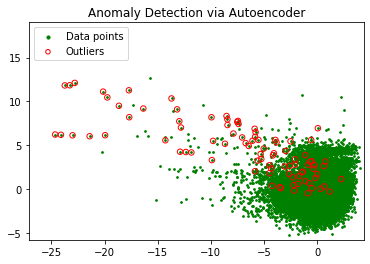

In [18]:
# Plot all data points according to the top two selected features

plt.title("Anomaly Detection via Autoencoder")
plt.scatter(X1, X2, 
            color="g", 
            s=3, 
            label="Data points")

# Plot red circles around outliers in the dataset according to ground truth

plt.scatter(Y1, Y2, 
            s=30,
            edgecolors="r",
            facecolors="none", 
            label="Outliers")
plt.axis("tight")
plt.xlim((1.1*min(X1), 1.1*max(X1)))
plt.ylim((1.1*min(X2), 1.5*max(X2)))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()